# TO DO
1. Figure out dataset
2. Break down into individual characters
3. Form corpus from dataset for input and output characters
4. Assign a number to each character
5. Model will have an embedding so it will handle it
6. Output will be a bunch of integers so we will have to decode it

In [1]:
import tarfile
import os
import pandas as pd
import keras
import numpy as np
from keras.layers import LSTM, Dense, Embedding, Input
from keras.models import Model
from keras.utils.vis_utils import plot_model

In [2]:
!wget -nc https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

if not os.path.isdir('/content/dakshina_dataset_v1.0'):
  tarfile.open("/content/dakshina_dataset_v1.0.tar").extractall() 

--2021-04-25 18:36:34--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.164.144, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  25.2MB/s    in 18s     

2021-04-25 18:36:52 (109 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



# Loading Data

In [37]:
class data_loader():

  @staticmethod
  def _load_raw_df(languages = ["hi", "mr"]):
    lex = dict()
    lex['train'], lex['val'], lex['test'] = [], [], [] 
    column_names = ['input', 'output', 'count']
    
    for la in languages:
      lex['train'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.train.tsv', sep='\t', header=None, names=column_names))
      lex['val'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.dev.tsv', sep='\t', header=None, names=column_names))
      lex['test'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.test.tsv', sep='\t', header=None, names=column_names))

    lex['train'] = pd.concat(lex['train'])
    lex['val'] = pd.concat(lex['val'])
    lex['test'] = pd.concat(lex['test'])

    return lex    

  @staticmethod
  def _make_final_df(lex):
    
    for div in ['train', 'val', 'test']:
    
      # removing non max transliterations
      idx = lex[div].groupby(['input'])['count'].transform(max) == lex[div]['count']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # calclulating difference in lengths of various transliterations
      lex[div]['input_len'] = lex[div].apply(lambda x: len(str(x['input'])), axis=1)
      lex[div]['output_len'] = lex[div].apply(lambda y: len(str(y['output'])), axis=1)
      lex[div]['mod_dif'] = lex[div].apply(lambda z: abs(z['input_len'] - z['output_len']), axis=1) 

      # removing transliterations that vary by a lot in length
      idx = lex[div].groupby(['input'])['mod_dif'].transform(min) == lex[div]['mod_dif']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # removing duplicates if any remain
      lex[div].drop_duplicates(subset='input', keep='first', inplace=True)

      # removing redundant columns
      lex[div].drop(labels=['count', 'input_len', 'output_len', 'mod_dif'], inplace=True, axis=1)

    return lex

  @staticmethod
  def _generate_batch(X, y, data_dict, num_decoder_tokens, batch_size = 1):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, data_dict['max_source_length']),dtype='float32')
            decoder_input_data = np.zeros((batch_size, data_dict['max_target_length']),dtype='float32')
            decoder_target_data = np.zeros((batch_size, data_dict['max_target_length'], num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text):
                  encoder_input_data[i, t] = word
                for t, word in enumerate(target_text):
                    if t<len(target_text)-1:
                        decoder_input_data[i, t] = word # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        #print(word)
                        decoder_target_data[i, t - 1, word] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [26]:
class Tokenizer:

  def __init__(self, df):

    self.start_token = '<STR>'
    self.stop_token = '<STP>'
    self.unknown_token = '<UNK>'

    self.input_corpus = [self.start_token, self.stop_token, self.unknown_token]
    self.output_corpus = [self.start_token, self.stop_token, self.unknown_token]

    input_words = df.input.tolist()
    output_words = df.output.tolist()

    for word in input_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.input_corpus:
          self.input_corpus.append(token)

    for word in output_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.output_corpus:
          self.output_corpus.append(token)
    
    self.encode_dict_input = {self.input_corpus[i] : i+1 for i in range(len(self.input_corpus))}
    self.decode_dict_input = {k:v for v,k in self.encode_dict_input.items()}
    
    self.encode_dict_output = {self.output_corpus[i] : i+1 for i in range(len(self.output_corpus))}
    self.decode_dict_output = {k:v for v,k in self.encode_dict_output.items()}

  # takes in lists of words and returns lists of integers
  def encode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for word in X:
        word = str(word)
        # integer_list = [self.encode_dict_input[self.start_token]] + [self.encode_dict_input.get(token, self.encode_dict_input[self.unknown_token]) for token in word] + [self.encode_dict_input[self.stop_token]]
        integer_list =np.array([self.encode_dict_input.get(token, self.encode_dict_input[self.unknown_token]) for token in word])
        input_list.append(integer_list)
      
      return input_list
    
    if (mode=='output'):
      output_list = []
      for word in X:
        word = str(word)
        integer_list = np.array([self.encode_dict_output[self.start_token]] + [self.encode_dict_output.get(token, self.encode_dict_output[self.unknown_token]) for token in word] + [self.encode_dict_output[self.stop_token]])
        output_list.append(integer_list)
      
      return output_list
    

  # takes in lists of integers and returns lists of words
  def decode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for integers in X:
        token_list = [self.decode_dict_input.get(integer, '0') for integer in integers] 
        input_list.append(''.join(token_list))
      
      return input_list

    if (mode=='output'):
      output_list = []
      for integers in X:
        token_list = [self.decode_dict_output.get(integer, '0') for integer in integers[1:-1]] 
        output_list.append(''.join(token_list))
      
      return output_list

In [27]:
# def generate_batch(X = X_train, y = Y_train, batch_size = 1):
#   ''' Generate a batch of data '''
#   while True:
#     for j in range(0, len(X), batch_size):
#         encoder_input_data = np.zeros((batch_size, max_source_length),dtype='float32')
#         decoder_input_data = np.zeros((batch_size, max_target_length),dtype='float32')
#         decoder_target_data = np.zeros((batch_size, max_target_length, num_decoder_tokens),dtype='float32')
#         for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
#             for t, word in enumerate(input_text):
#               encoder_input_data[i, t] = word
#             for t, word in enumerate(target_text):
#                 if t<len(target_text)-1:
#                     decoder_input_data[i, t] = word # decoder input seq
#                 if t>0:
#                     # decoder target sequence (one hot encoded)
#                     # does not include the START_ token
#                     # Offset by one timestep
#                     #print(word)
#                     decoder_target_data[i, t - 1, word] = 1.
                
#         yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [62]:
def return_data_dict(languages=['hi', 'mr'], batch_size=32):

  lex = data_loader._load_raw_df(languages)
  lex = data_loader._make_final_df(lex)

  data_dict = dict()

  df_train = lex['train']
  df_val = lex['val']
  df_test = lex['test']

  tk = Tokenizer(df_train)

  data_dict['in_size'] = len(tk.input_corpus) + 1
  data_dict['out_size'] = len(tk.output_corpus) + 1

  X_train = tk.encode(df_train.input.tolist(), mode='input')
  Y_train = tk.encode(df_train.output.tolist(), mode='output')
  X_val = tk.encode(df_val.input.tolist(), mode='input')
  Y_val = tk.encode(df_val.output.tolist(), mode='output')
  X_test = tk.encode(df_test.input.tolist(), mode='input')
  Y_test = tk.encode(df_test.output.tolist(), mode='output')

  max_source_length = np.max(np.array([len(x) for x in X_train]))
  max_target_length = np.max(np.array([len(x) for x in Y_train]))

  data_dict['train'], data_dict['val'], data_dict['test']= dict(), dict(), dict()

  data_dict['train']['df'] = df_train
  data_dict['val']['df'] = df_val
  data_dict['test']['df'] = df_test

  data_dict['train']['max_source_length'] = np.max(np.array([len(x) for x in X_train]))
  data_dict['train']['max_target_length'] = np.max(np.array([len(x) for x in Y_train]))
  data_dict['val']['max_source_length'] = np.max(np.array([len(x) for x in X_val]))
  data_dict['val']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))
  data_dict['test']['max_source_length'] = np.max(np.array([len(x) for x in X_test]))
  data_dict['test']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))

  data_dict['train']['batch'] = data_loader._generate_batch(X_train, Y_train, data_dict['train'], data_dict['out_size'], batch_size)
  data_dict['val']['batch'] = data_loader._generate_batch(X_val, Y_val, data_dict['val'], data_dict['out_size'], batch_size)
  data_dict['test']['batch'] = data_loader._generate_batch(X_test, Y_test, data_dict['test'], data_dict['out_size'], batch_size)  
  
  data_dict['tokenizer'] = tk

  return data_dict

In [ ]:
# data = dict()
# data['train'] = dict()
# data['train']['X'] = X_train
# data['train']['Y'] = Y_train
# data['in_size'] = len(tk.input_corpus) + 1
# data['out_size'] = len(tk.output_corpus) + 1
# num_decoder_tokens = data['out_size'] 
# max_source_length = np.max(np.array([len(x) for x in X_train]))
# max_target_length = np.max(np.array([len(x) for x in Y_train]))

# Question 1


In [ ]:
class rnn():

  def __init__(self, params):
    num_encode_layers = params['num_encode_layers']
    num_decode_layers = params['num_decode_layers']
    data = params['data']
    in_size = params['data']['in_size']
    out_size = params['data']['out_size']
    cell_type = params['cell_type']
    dropout = params['dropout']
    embed_size = params['embed_size']
    rep_size = params['rep_size']


    
    encoder_inputs = Input(shape=(None,))
    x = Embedding(data['in_size'], embed_size ,mask_zero=True)(encoder_inputs)
    encode_layers = []
    for j in range(num_encode_layers-1) :
      if cell_type == 'RNN' :
        curr_layer = layers.SimpleRNN(rep_size,dropout=dropout,return_sequences=True)
      elif cell_type == 'GRU' :
        curr_layer = layers.GRU(rep_size,dropout=dropout,return_sequences=True)
      elif cell_type == 'LSTM' :
        curr_layer = layers.LSTM(rep_size,dropout=dropout,return_sequences=True)

      encoder_layer.append(curr_layer)
      x = curr_layer(x)

    if cell_type == 'RNN' :
      curr_layer = layers.SimpleRNN(rep_size,dropout=dropout,return_state=True)
    elif cell_type == 'GRU' :
      curr_layer = layers.GRU(rep_size,dropout=dropout,return_state=True)
    elif cell_type == 'LSTM' :
      curr_layer = layers.LSTM(rep_size,dropout=dropout,return_state=True)
    
    encoder_layer.append(curr_layer)
    x, state_h, state_c = curr_layer(x)
    encoder_states = [state_h, state_c]
    decoder_inputs = Input(shape=(None,))
    decoder_layers = []
    decoder_embedding =  Embedding(data['out_size'],embed_size,mask_zero=True)
    x =decoder_embedding(decoder_inputs)
    
    if cell_type == 'RNN' :
      curr_layer = layers.SimpleRNN(rep_size,dropout=dropout,return_state=True, return_sequences=True)
    elif cell_type == 'GRU' :
      curr_layer = layers.GRU(rep_size,dropout=dropout,return_state=True, return_sequences=True)
    elif cell_type == 'LSTM' :
      curr_layer = layers.LSTM(rep_size,dropout=dropout,return_state=True, return_sequences=True)

    decoder_layers.append(curr_layer)
    x,_,_ = curr_layer(x, initial_state=encoder_states)

    for j in range(num_decode_layers) :
      if cell_type == 'RNN' :
        model.add(layers.SimpleRNN(rep_size,dropout=dropout,return_state=True, return_sequences=True))
      elif cell_type == 'GRU' :
        model.add(layers.GRU(rep_size,dropout=dropout,return_state=True, return_sequences=True))
      elif cell_type == 'LSTM' :
        model.add(layers.LSTM(rep_size,dropout=dropout,return_state=True, return_sequences=True))
      
      decoder_layers.append(curr_layer)
      x,_,_ = curr_layer(x)
      

    
    /**********************************************************
    x, state_h, state_c = LSTM(units=256,
                              return_state=True)(x)
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None,))
    decoder_embedding =  Embedding(data['out_size'], 64,mask_zero=True)
    x =decoder_embedding(decoder_inputs)
    decoder_LSTM = LSTM(units=256, return_sequences=True,return_state=True)
    x,_,_ = decoder_LSTM(x, initial_state=encoder_states)
    decoder_dense = Dense(units=data['out_size'], activation='softmax')
    decoder_outputs = decoder_dense(x)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    ********************************************************************/

  def compile_and_fit(self,data,params):
    train_ds, val_ds = data['train'], data['val']
    optimizer, epochs = params['optimizer'], params['num_epochs']
    if optimizer == 'NAG' :
      optimizer = tf.keras.optimizers.SGD(momentum=0.9,nesterov=True)
    self.model.compile(optimizer=optimizer, 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                       metrics=['accuracy']
                       )
    
    summary = self.model.summary()

    run_details = self.model.fit(train_ds, 
                                 validation_data=val_ds, 
                                 epochs=epochs,
                                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                          patience=3, 
                                                                          min_delta=0.0025)]
                                 )

    return {
        'run_details' : run_details
    }



In [ ]:
params = {
    'num_encode_layers' : 1,
    'num_decode_layers' : 1,
    'cell type' : 'RNN' ,
    'data' : data,   
}

In [61]:
encoder_inputs = Input(shape=(None,))
x = Embedding(data_dict['in_size'], 64,mask_zero=True)(encoder_inputs)
x = LSTM(units=256,return_sequences=True)(x)
x, state_h, state_c = LSTM(units=256,
                           return_state=True)(x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
decoder_embedding =  Embedding(data_dict['out_size'], 64,mask_zero=True)
x =decoder_embedding(decoder_inputs)
decoder_LSTM = LSTM(units=256, return_sequences=True,return_state=True)
x,_,_ = decoder_LSTM(x, initial_state=encoder_states)
decoder_dense = Dense(units=data_dict['out_size'], activation='softmax')
decoder_outputs = decoder_dense(x)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
class BeamSearchCallBack(keras.callbacks.Callback):
  pass

In [8]:
# model.summary()

In [9]:
# plot_model(model,show_shapes=True)

In [ ]:
X_train = [np.array(x) for x in X_train]
print(X_train[:5])

[array([1, 4, 5, 2]), array([ 1,  4,  5,  6,  7,  8,  9, 10,  2]), array([ 1,  4,  5,  6, 11,  2]), array([ 1,  4,  5,  6, 12, 13,  2]), array([ 1,  4,  5,  6, 12, 13,  8,  2])]


In [ ]:
Y_train = [np.array(y) for y in Y_train]
print(Y_train[:5])

[array([1, 4, 5, 2]), array([1, 4, 5, 6, 7, 4, 5, 8, 9, 2]), array([ 1, 10,  5, 11, 12, 13,  2]), array([ 1,  4,  5,  6, 10, 14,  2]), array([ 1,  4,  5,  6, 10, 14,  4,  5,  2])]


In [64]:
train_samples = len(data_dict['train']['df']) # Total Training samples
val_samples = len(data_dict['val']['df'])    # Total validation or test samples
batch_size = 32
epochs = 30

In [65]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [66]:
model.fit_generator(generator = data_dict['train']['batch'],
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    callbacks=[]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
710/710 [==============================] - 52s 17ms/step - loss: 0.8963 - acc: 0.3112
Epoch 2/30
710/710 [==============================] - 13s 18ms/step - loss: 0.8411 - acc: 0.3997
Epoch 3/30
710/710 [==============================] - 12s 17ms/step - loss: 0.7253 - acc: 0.3902
Epoch 4/30
710/710 [==============================] - 12s 17ms/step - loss: 0.6986 - acc: 0.4853
Epoch 5/30
710/710 [==============================] - 12s 17ms/step - loss: 0.6168 - acc: 0.4716
Epoch 6/30
710/710 [==============================] - 13s 18ms/step - loss: 0.5665 - acc: 0.5645
Epoch 7/30
710/710 [==============================] - 12s 18ms/step - loss: 0.4981 - acc: 0.5643
Epoch 8/30
710/710 [==============================] - 13s 18ms/step - loss: 0.4296 - acc: 0.6685
Epoch 9/30
710/710 [==============================] - 13s 18ms/step - loss: 0.3862 - acc: 0.6685
Epoch 10/30
710/710 [==============================] - 13s 18ms/step - loss: 0.3212 - acc: 0.7584
Epoch 11/30
710/710 [========

In [ ]:
X_test = tk.encode(lex['test'].input.tolist())
Y_test = tk.encode(lex['test'].output.tolist(),'output')

In [ ]:
sd = generate_batch(X_test,Y_test)

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_emb2 = decoder_embedding(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_LSTM(dec_emb2
                                                    ,initial_state=decoder_state_input
                                                    )
decoder_states2 = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs2] + decoder_states2)

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     1920        input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

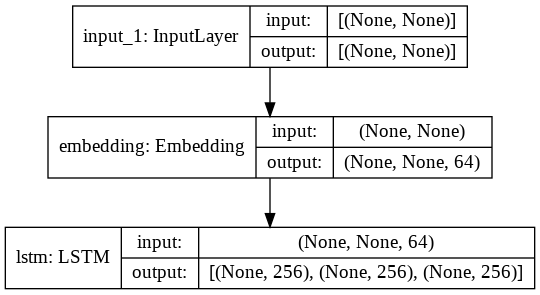

In [ ]:
plot_model(encoder_model,show_shapes=True)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = 1
# Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    chars = [1]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
# Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 2 :
          stop_condition = True
        chars.append(sampled_token_index)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
# Update states
        states_value = [h, c]
    return tk.decode([chars],'output')[0]

In [ ]:
test_gen = generate_batch(X_test, Y_test, batch_size = 1)
k=-1

In [ ]:
x1 = tk.encode(['टोप्पर​'])
x1

[[1, 29, 24, 35, 18, 35, 13, 3, 2]]

In [ ]:
decode_sequence(x1)

'toppram'

In [ ]:
lex['test'].input.tolist()[k]

'अचीवमेंट'

In [ ]:
k += 1
(input_seq, actual_output), _ = next(test_gen)
# print(input_seq)
decoded_sentence = decode_sequence(input_seq)
print('Input Source sentence:', tk.decode([X_test[k]])[0] )
print('Actual Target Translation:', tk.decode([Y_test[k]],mode='output')[0])
print('Predicted Target Translation:', decoded_sentence)

Input Source sentence: अंकों
Actual Target Translation: ankon
Predicted Target Translation: aankon


# Romanized

In [ ]:
ta_rom = dict()
ta_rom['rejoined'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.tsv', sep='\t', header=None, error_bad_lines=False)
ta_rom['rejoined_aligned_cased'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.aligned.cased_nopunct.tsv', sep='\t', header=None, error_bad_lines=False) 
ta_rom['rejoined_aligned'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.aligned.tsv', sep='\t', header=None, error_bad_lines=False)
ta_rom['split'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.split.tsv', sep='\t', header=None, error_bad_lines=False)

b'Skipping line 1096: expected 2 fields, saw 3\nSkipping line 1581: expected 2 fields, saw 3\n'
b'Skipping line 33794: expected 2 fields, saw 3\nSkipping line 33795: expected 2 fields, saw 3\nSkipping line 33796: expected 2 fields, saw 3\nSkipping line 33798: expected 2 fields, saw 3\nSkipping line 33799: expected 2 fields, saw 3\nSkipping line 33801: expected 2 fields, saw 3\nSkipping line 33802: expected 2 fields, saw 3\nSkipping line 33803: expected 2 fields, saw 3\n'
b'Skipping line 11317: expected 2 fields, saw 4\nSkipping line 16502: expected 2 fields, saw 4\nSkipping line 32577: expected 2 fields, saw 3\nSkipping line 32578: expected 2 fields, saw 3\nSkipping line 32579: expected 2 fields, saw 3\nSkipping line 32581: expected 2 fields, saw 3\nSkipping line 32582: expected 2 fields, saw 3\nSkipping line 32584: expected 2 fields, saw 3\nSkipping line 32585: expected 2 fields, saw 3\nSkipping line 32586: expected 2 fields, saw 3\n'
b'Skipping line 1108: expected 7 fields, saw 9\nSk

In [ ]:
list(ta_rom['rejoined'].iloc[0, 0])[:10]

['ர', 'ே', 'ட', 'ி', 'ய', 'ோ', ' ', 'அ', 'த', 'ி']

In [ ]:
ta_rom['rejoined_aligned_cased']

,0,1
0,ரேடியோ,radio
1,அதிர்வெண்,athirven
2,முடுக்கிகள்,mudikkigal
3,துகள்கள்,thugalkal
4,நேரடியாக,neradiyaga
...,...,...
104779,இவ்விதழின்,ivvithazhin
104780,விலை,vilai
104781,ரூபாய்,roobaay
104782,1.00,1.00


In [ ]:
ta_rom['rejoined_aligned']

NameError: ignored

In [ ]:
ta_rom['split']

,0,1,2,3,4,5,6
0,"ரேடியோ அதிர்வெண் முடுக்கிகள், துகள்கள் நேரடியா...",6,"Radio athirven mudikkigal, thugalkal neradiyag...",6.0,NaN,NaN,NaN
1,மான் விளையாடிக்கொண்டு வந்து உன்னை மோதினால் உன்...,21,Maan vilaiyaadikondu vanthu unnai modhinaal un...,21.0,NaN,NaN,NaN
2,அமிர்தகழி,1,Amirthakazhi,1.0,NaN,NaN,NaN
3,மோகன் லால் குப்தா ஜெய்ப்பூரின் முன்னாள் மேயராக...,12,"Mohan Lal Gupta Jaipaurin munnal mayoragavum, ...",12.0,NaN,NaN,NaN
4,தில்லி மாநில கூட்டுறவு வங்கி லி.,5,Delhi maanila kooturavu vangi li.,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
9982,என்றாலும் வில்லியம் இறந்த பிறகான கரோலினின் பணி...,27,Yendraalum William irandha piragaana Carolinin...,27.0,NaN,NaN,NaN
9983,தொல்பொருளியல் அச்சகம் (Archaeopress) என்பது இங...,14,Tholporuliyal achchagam (Archaeopress) yenbath...,14.0,NaN,NaN,NaN
9984,மலைய நாட்டு மன்னனை மலாடர் கோமான் என்று சங்கப்ப...,8,Malaiya naattu mannanai malaadar komaan yendru...,8.0,NaN,NaN,NaN
9985,"அப்படையின் தொகை மிக அருகி இருந்ததோடு, அதனிடம் ...",12,"Appadaiyin thogai miga arugi irunthathodu, ath...",12.0,NaN,NaN,NaN
